In [3]:
#Use this script to generate all necessary input files to calculate the electron phonon coupling of a system using the
#EPW package of Quantum Espresso. 
#The calculations need to be run on a cluster with IBM® Platform™ LSF® implementation however modifying it
#to run on different workload schedulers like SLURM should not be difficult (positions of necessary changes are denoted by "LSF" in this script).

#The script will generate a parent directory called $base_dir which itself contains the following directories:
# - ELB (directory for electron band calculations)
# - PHB (phonon bands)
# - EPM (electron phonon matrix, phonon linewidhts and Eliashberg spectral function)
# - ISO (solving the isotropic Eliashberg equations)

#All you need to do is to specify the calculation parameters below and then run the submission scripts called
#ep_bands.sh and epw.sh on the cluster in that order.
#ep_bands.sh will prepare and submit the calculations for the electron and phonon bands. Because image parallelization
#does not work for the needed type of phonon calculations, this script splits the phonon calculation into multiple calculations;
#one calculation for each irreducible q-point and additionally one calculation for every irreducible representation of
#each irreducible q-point. This splitting can also be disabled.

#Once the electron and phonon band calculations are finished, check the results and then execute epw.sh.
#This will update the EPW input files with the data from the electron and phonon bands calculations and then submit them.

#Check the submission scripts for further options/instructions.

#Any calculation parameters that are missing or have been "hardcoded" should be easy enough
#to introduce/change in the input lists called *_in. Everything should still work if you wish to do so.

#______________________RUN_ENVIRONMENT_______________________#
#prefix for any data files
pf = 'Pm-3m_q8_e0_bands'  
#name of the parent directory created by this script
base_dir = 'Pm-3m_q8_e0_bands' 
#name of job on Euler. Be mindful of regex metacharacters
jobname = base_dir
#location of the pseudopotentials where the calculations are run
pps_dir = '/cluster/scratch/mnoe/QE/pps' 
#number of processors to be used for scf, bands and nscf calculations
num_of_cpu_scf = 16
#number of precessors to be used for the phonon calculations (i.e. if you split the calculation into calculations of
#irreducible modes, each of these calculations will be run with the specified amount of CPUs)
num_of_cpu_ph = 8
#number of processors to be used for any epw calculation
num_of_cpu_epw = 96
#memory per cpu
ram = 3072
#time limit in hours for scf, nscf and bands calculations
scf_t = 4
#time limit in hours for phonon calculations, i.e. for the whole calculation or per irreducbile q-point or irreducible representation
#depending on whether the phonon calculations are split or not
q_t = 4
#time limit in hours for epw calculations 
epw_t = 72
#specify if phonon calculations should be split into calculations of irreducible q-points
split_q = True
#specify if phonon calculations should additionally be split into calculations of irreducible represenations.
#split_q is automatically enabled if split_irr is enabled and split_irr is disabled if split_q is disabled.
split_irr = True
#if the right electron and phonon bands have already been calculated in another parent directory you can set
#ref_bands to True. epw.sh will then run with the corresponding input of the parent directory s.t. the bands
#don't have to be recalculated (start from 2nd submission script).
#If you set ref_bands to False you need to calculate the bands first (start form 1st submission script).
ref_bands = True
#Parent directory containing the already calculated bands (in the respective ELB and PHB directories).
#You only need to specify this if ref_bands = True.
#If ref_bands = True the prefix has to be the same as the one for the phonon calculations
bands_dir = '/cluster/scratch/mnoe/QE/EPC/Pm-3m_00_q6_e01_bands'


#note: time limits for calculations which should not take long have been set to 4h (shortest cluster limit)
#these include wannier, bands_ip, q2r, matdyn


#__________________________STRUCTURE__________________________#
#lattice vectors in Angstrom
#Syntax:
#'''
#CELL_PARAMETERS angstrom
#$v1(1) $v1(2) $v1(3)
#$v2(1) $v2(2) $v2(3)  
#$v3(1) $v3(2) $v3(3)
#'''
lattice = '''
CELL_PARAMETERS angstrom
        3.7959315000      0.0000000000         0.0000000000
        0.0000000000      3.7959315000         0.0000000000
        0.0000000000      0.0000000000         3.7959315000
'''
#number of atoms in the unit cell
num_of_atoms = 4

#number of distinct atom types in unit cell
num_of_atom_types = 2                 

#atom type specification as required in pw.x input file
#Syntax:
#'''
#ATOMIC_SPECIES
#$atom_label_1 $atom_weight_1 $pps_filename_1
#$atom_label_2 $atom_weight_2 $pps_filename_2
#etc.
#'''
atoms = '''                            
ATOMIC_SPECIES
W 183.84 W_ONCV_LDA-4.0.upf
O 15.9994 O_ONCV_LDA-3.0.upf
'''

#Atomic positions in relative positions to the lattice vectors
#Syntax: 
#'''
#ATOMIC_POSITIONS crystal
#   $atom_label_1 $x1 $y1 $z1
#   $atom_label_2 $x2 $y2 $z2
#   $atom_label_3 $x3 $y3 $z3
#   etc.
#'''

atom_positions = '''
ATOMIC_POSITIONS crystal
  W 0.5000000000000000  0.5000000000000000  0.5000000000000000
  O 0.5000000000000000  0.5000000000000000  0.0000000000000000
  O 0.5000000000000000  0.0000000000000000  0.5000000000000000
  O 0.0000000000000000  0.5000000000000000  0.5000000000000000
'''

#____________________CALCULATION_PARAMETERS____________________#
#plane wave cut-off energy in Ry
e_cut = 120  
#coarse k-grid size
k_x = 12
k_y = 12
k_z = 12
#coarse q-grid size. The q and k-grid sizes need to be whole multiples of each other
q_x = 8
q_y = 8
q_z = 8
#fine grid sizes
kf_x = 60
kf_y = 60
kf_z = 60
qf_x = 60
qf_y = 60
qf_z = 60
#for random fine grids, set random_sampling to True and specify the number of respective random points.
random_sampling = True
random_nkf = 50000
random_nqf = 25000

#number of bands calculated. Set to 0 if this should be determined automatically.
num_of_bands = 0    
#amount of additional charge per unit cell (electrons negative, holes positive). currently only electron doping possible
nelect = -0.0
#accoustic sum rule type ('simple', 'crystal', 'one-dim', 'zero-dim', 'no' to disable)
asr_type = 'simple'

#scf convergence threshold in Ry
delta_scf = '1.0d-8'
#phonon convergence threshold in Ry^2
delta_ph = '1.0d-14'

#scf diagonalization algorithm ('cg' or 'david'). You might run into problems for EPW calculations if you use david
diag_algo = 'david'

                    

#____________________HIGH_SYMMETRY_LINES_______________________#
#define an array of high symmetry points.
#Syntax: ['$point_label_1 $k_x1 $k_y1 $k_z1', '$point_label_2 $k_x2 $k_y2 $k_z2', etc]
hisym_points = ['G 0 0 0', 
                'X 0.5 0 0',
                'M 0.5 0.5 0',
                'R 0.5 0.5 0.5'
               ]
#define the high symmetry paths using the point labels defined in hisym_points
#Syntax: ['$point_label_1', '$point_label_2', '$point_label_1', etc. ]
hisym_path = ['G', 'M', 'X', 'G', 'R', 'M', 'G']

#number of interpolation points per high symmetry line
path_prec = 100


#_________________________WANNIERIZATION_______________________#
#The parameters for the wannierization can also be changed in the epw.sh script once you have obtained 
#the electron bands and you want to adjust them. 

#number of bands at and above the Fermi energy that get wannierized. 
#This needs to correspond to the right number implied by your specified projections.
num_of_wan = 3
#array of initial projections for Wannier functions. Check wannier90 documentation for syntax.
#Set to 'random' if you have no initial guess
#Syntax: ['$proj1', '$proj2', etc.] (example: ['random', 'W:l=2,mr=2,3,5'])
wannier_init = ['W:l=2,mr=2,3,5']

#automatic wannierization window determination
auto_window = True

#manual wannierization window specification. You only need to specify these parameters
#if auto_window = False or if the automatic determination doesn't work.
#highest band that does not get wannierized,i.e. the $num_of_wan bands after band $wan_min get wannierized
wan_min = 16
#inner wannierization window (in eV)
inner_bottom = 0.0
inner_top = 0.0
#outer wannierization window (n eV)
outer_bottom = 0.0
outer_top = 0.0

#___________________CRITICAL TEMPERATURE_______________________#
#!!!!!!!!!!!!!!!!!!! NOT WORKING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#minimum temperature in K for which superconducting gap is calculated
T_min = 0
#maximum temperature in K
T_max = 10
#temperature points between T_min and T_max for which superconducting gap is calculated
num_of_T = 10
#___________________________END________________________________#
#____________________NOW_RUN_THE_SCRIPT________________________#

import os
import string
import math

if not os.path.exists(base_dir):
    os.makedirs(base_dir) 
    
if not os.path.exists(os.path.join(base_dir, 'ELB')):
    os.makedirs(os.path.join(base_dir, 'ELB')) 
    
if not os.path.exists(os.path.join(base_dir, 'PHB')):
    os.makedirs(os.path.join(base_dir, 'PHB')) 
    
if not os.path.exists(os.path.join(base_dir, 'EPM')):
    os.makedirs(os.path.join(base_dir, 'EPM')) 

if not os.path.exists(os.path.join(base_dir, 'ISO')):
    os.makedirs(os.path.join(base_dir, 'ISO')) 
    
path_prec = str(path_prec)
num_of_hsp = len(hisym_path)  

#get the k-points for bands.in and matdyn.in
kpoints = ''''''
for hisym_point in hisym_path:
    for i in range(0, len(hisym_points)):
        hisym_point_comp = hisym_points[i].split(' ')[0]
        if hisym_point == hisym_point_comp:
            kpoints += hisym_points[i].split(' ')[1] + '\t' + hisym_points[i].split(' ')[2] + '\t' + \
                                    hisym_points[i].split(' ')[3] + '\t' + path_prec
            kpoints += '\n'            

#get the k-points for wannier90
index = 0
kpoints_wannier = ''''''
for hisym_point in hisym_path:
    for i in range(0, len(hisym_points)):
        hisym_point_comp = hisym_points[i].split(' ')[0]
        if hisym_point == hisym_point_comp:
            #first point in path
            if index == 0:
                kpoints_wannier += 'wdata(' + str(index+3) + ') = ' + '\'' + hisym_points[i].split(' ')[0] + '\t' + \
                                   hisym_points[i].split(' ')[1] + '\t' + \
                                   hisym_points[i].split(' ')[2] + '\t' + hisym_points[i].split(' ')[3] + '\t'
                index += 1
            #last point in path
            elif index == (len(hisym_path) - 1):
                kpoints_wannier += hisym_points[i].split(' ')[0] + '\t' + hisym_points[i].split(' ')[1] + '\t' + \
                                   hisym_points[i].split(' ')[2] + '\t' + hisym_points[i].split(' ')[3] + '\'' 
           #intermediate point
            else:
                kpoints_wannier += hisym_points[i].split(' ')[0] + '\t' + hisym_points[i].split(' ')[1] + '\t' + \
                                   hisym_points[i].split(' ')[2] + '\t' + hisym_points[i].split(' ')[3] + '\''
                kpoints_wannier += '\n'
                kpoints_wannier += '    ' + 'wdata(' + str(index+3) + ') = ' + '\'' + hisym_points[i].split(' ')[0] + '\t' + \
                                   hisym_points[i].split(' ')[1] + '\t' + \
                                   hisym_points[i].split(' ')[2] + '\t' + hisym_points[i].split(' ')[3] + '\t'
                index += 1
                
kpoints_wannier += '\n'
kpoints_wannier += '    ' + 'wdata(' + str(len(hisym_path) + 2) + ') = \'end kpoint_path\''
kpoints_wannier += '\n'
kpoints_wannier += '    ' + 'wdata(' + str(len(hisym_path) + 3) + ') = \'bands_num_points =' +  path_prec + '\''

#get the projections for wannier90
index = 0
projections = ''''''
for p in wannier_init:
    projections += 'proj(' + str(index+1) + ') = \'' + str(p) + '\''+ '\n' + '\t' 
    index += 1
    
#get the projections for epw.sh
projections_epw = '''('''
for p in wannier_init:
    projections_epw +=  '\"' + p + '\" '
projections_epw = projections_epw[:-1]
projections_epw += ')'
    
#function to create job submission files
#LSF
def make_job_sub(_jobname,_num_of_cpu, _ram, _time, _infile, _outfile, _program, _condition, _escape=False):
    job_sub = ''''''
    job_sub += '#!/bin/bash' + '\n'
    job_sub += '#BSUB -n ' + str(_num_of_cpu)  + '\n'
    job_sub += '#BSUB -R \"' + "rusage[mem=" + str(_ram)  + ']\"\n'
    job_sub += '#BSUB -W ' + str(_time)  + ':00' + '\n'
    job_sub += '#BSUB -o ' + _jobname  + '.o' + '\n'
    job_sub += '#BSUB -e ' + _jobname  + '.e' + '\n'
    job_sub += '#BSUB -J ' + _jobname + '\n'
    if not _condition == '':
        job_sub += '#BSUB -w ' + _condition  + '\n'
    if not _program == '':
        job_sub += 'mpirun ' + _program + ' -npool ' + str(_num_of_cpu) + ' -in ' + _infile + ' > ' + _outfile
    if _escape == True:
        job_sub = job_sub.replace("#", "\#")
    return str(job_sub)

#function to check if conditions need to be removed and if submission scripts need to be submitted
#LSF
def check_cond_sub(_index, _scf = False):
    cond_sub = ''''''
    if not _scf:
        cond_sub += 'if (($calc_start == ' + str(_index) + '))' + '\n' + 'then' + '\n'
        cond_sub += 'line=$(grep -n \"#BSUB -w\" job.sh' + ' | cut -d : -f 1)' + '\n'
        cond_sub += 'sed -i ${line}d job.sh' + '\n' + 'fi' + '\n'
    
    cond_sub += 'if ! $no_sub' + '\n' + 'then' + '\n'
    cond_sub += 'bsub<job.sh' + '\n' + 'fi' + '\n'
    return str(cond_sub)
    
    
#function to generate coarse and fine grid specification for epw input
def generate_fine_grids(_random_sampling, _random_nkf, _random_nqf,
                   _kf_x, _kf_y, _kf_z, _qf_x, _qf_y, _qf_z, _file_q = False, _prefix = ""):
    grids = ''''''
    if _random_sampling:
        grids += 'rand_k = .true.' + '\n' + '    '       
        grids += 'rand_nk = ' + str(_random_nkf) + '\n' + '    '
        if not _file_q:
            grids += 'rand_q = .true.' + '\n' + '    '
            grids += 'rand_nq = ' + str(_random_nqf) + '\n' + '    '
        else:
            grids +=  'filqf = \'' + str(_prefix) + '_band.kpt\'' + '\n' + '    '
    else:
        grids += 'nkf1 = ' + str(_kf_x) + '\n' + '    '
        grids += 'nkf2 = ' + str(_kf_y) + '\n' + '    '
        grids += 'nkf3 = ' + str(_kf_z) + '\n' + '    '
        if not _file_q:
            grids += 'nqf1 = ' + str(_qf_x) + '\n' + '    '
            grids += 'nqf2 = ' + str(_qf_y) + '\n' + '    '
            grids += 'nqf3 = ' + str(_qf_z) + '\n' + '    '
        else:
            grids +=  'filqf = \'' + str(_prefix) + '_band.kpt\'' + '\n' + '    '
    return str(grids)
    
asr_enable = '.false.'
if asr_type == 'simple' or asr_type == 'crystal' or asr_type == 'one-dim' or asr_type == 'zero-dim':
    asr_enable = '.true.'

if auto_window == True:
    auto_window = 'true'
else:
    auto_window = 'false'
    
if split_q == True:
    split_q = 'true'
else:
    split_q = 'false'
    
if split_irr == True:
    split_irr = 'true'
else:
    split_irr = 'false'

dvscf_dir = '../PHB/save'
if ref_bands == True:
    ref_bands = 'true'
    dvscf_dir = bands_dir +  '/PHB/save'
else:
    ref_bands = 'false'
   
        
#_______________________________________INPUT_LISTS_______________________________________#
#_________________________________________________________________________________________#
scf_in = ['''
&CONTROL
    calculation   = 'scf'
    restart_mode  = 'from_scratch'      
    prefix        = '{pf}'              
    pseudo_dir    = '{pps_dir}'         
    outdir        = './'
/
&SYSTEM   
    ibrav       = 0      
    nat         = {num_of_atoms}       
    ntyp        = {num_of_atom_types}   
    ecutwfc     = {e_cut}               
    occupations = 'smearing'           
    degauss     = 7.35d-4               
    tot_charge  = {nelect}              
/
&ELECTRONS
    conv_thr    = {delta_scf}              
    diagonalization = '{diag_algo}'              
/
{lattice}
{atoms}
{atom_positions}
K_POINTS automatic
{k_x} {k_y} {k_z} 0 0 0
'''.format(pf = pf, pps_dir = pps_dir, lattice = lattice,
           num_of_atoms = num_of_atoms, num_of_atom_types = num_of_atom_types, e_cut = e_cut, nelect = nelect, delta_scf = delta_scf,
           diag_algo = diag_algo, atoms = atoms, atom_positions = atom_positions, k_x = k_x, k_y = k_y, k_z = k_z)]

bands_in = ['''
&CONTROL
    calculation   = 'bands'
    restart_mode  = 'from_scratch'      
    prefix        = '{pf}'              
    pseudo_dir    = '{pps_dir}'         
    outdir        = './'
/
&SYSTEM    
    ibrav       = 0            
    nat         = {num_of_atoms}        
    ntyp        = {num_of_atom_types}   
    ecutwfc     = {e_cut}               
    occupations = 'smearing'            
    degauss     = 7.35d-4               
    tot_charge  = {nelect}              
    nbnd        = {num_of_bands}        
/
&ELECTRONS
    conv_thr    = {delta_scf}               
    diagonalization = '{diag_algo}'
/
{lattice}
{atoms}
{atom_positions}
K_POINTS crystal_b
{num_of_hsp}
{kpoints}
'''.format(pf = pf, pps_dir = pps_dir, lattice = lattice,
           num_of_atoms = num_of_atoms, num_of_atom_types = num_of_atom_types, e_cut = e_cut, nelect = nelect,
           num_of_bands = num_of_bands, delta_scf = delta_scf, diag_algo = diag_algo, atoms = atoms, atom_positions = atom_positions,
           num_of_hsp = num_of_hsp, kpoints = kpoints)]

bands_ip_in = ['''
&BANDS
 prefix='{pf}'
 outdir='.'
 filband = '{pf}bands.dat'
 lsym=.true.
/
'''.format(pf = pf)]

#the missing "/" at the end in ph_in is intended. Don't put one there.
ph_in = ['''
&INPUTPH
    prefix   = '{pf}'       
    outdir   = './'          
    fildyn   = '{pf}.dyn'    
    fildvscf = 'dvscf'       
    ldisp    = .true.        
    nq1      = {q_x}    
    nq2      = {q_y} 
    nq3      = {q_z} 
    asr      = {asr_enable}        
    tr2_ph   = {delta_ph}
    recover = .true.
'''.format(pf = pf, q_x = q_x, q_y = q_y, q_z = q_z, asr_enable = asr_enable, delta_ph = delta_ph)]

q2r_in = ['''
&INPUT
   fildyn='{pf}.dyn'
   zasr='{asr_type}'
   flfrc='{pf}.fc'           
/
'''.format(pf = pf, asr_type = asr_type)]

matdyn_in = ['''
&INPUT
    asr='{asr_type}'
    flfrc='{pf}.fc'
    flfrq='{pf}.freq'       
    q_in_band_form=.true.
/
{num_of_hsp}
{kpoints}
'''.format(pf = pf, num_of_hsp = num_of_hsp, kpoints = kpoints, asr_type = asr_type)]

#kpoints in nscf_in get appended when epw.sh is executed
nscf_in = ['''
&CONTROL
    calculation   = 'nscf',
    restart_mode  = 'from_scratch'       
    prefix        = '{pf}'              
    pseudo_dir    = '{pps_dir}'         
    outdir        = './'
/
&SYSTEM    
    ibrav       = 0          
    nat         = {num_of_atoms}        
    ntyp        = {num_of_atom_types}  
    ecutwfc     = {e_cut}               
    occupations = 'smearing'            
    degauss     = 7.35d-4               
    tot_charge  = {nelect}              
    nbnd        = {num_of_bands}
    nosym       = .true.                
/
&ELECTRONS
    conv_thr    = {delta_scf}               
    diagonalization = {diag_algo}
/
{lattice}
{atoms}
{atom_positions}
'''.format(pf = pf, pps_dir = pps_dir, lattice = lattice,
           num_of_atoms = num_of_atoms, num_of_atom_types = num_of_atom_types, e_cut = e_cut, nelect = nelect,
           num_of_bands = num_of_bands, delta_scf = delta_scf, diag_algo = diag_algo, atoms = atoms, atom_positions = atom_positions)]

wannier_in = ['''
&inputepw
    prefix      = '{pf}'
    outdir      = './'
    dvscf_dir   = '{dvscf_dir}'
    
    elph        = .false.
    epbwrite    = .false.         
    epwwrite    = .true.         
    
    wannierize  = .true.         
    nbndsub     =  {num_of_wan}             
    nbndskip    =  {wan_min}            
    num_iter    = 1000           
    dis_win_min = 0.0            
    dis_win_max = 0.0
    dis_froz_min = 0.0            
    dis_froz_max = 0.0
    
    {projections}      
    wdata(1) = 'bands_plot = .true.'
    wdata(2) = 'begin kpoint_path'
    {kpoints_wannier}
        
    nk1 = {k_x}
    nk2 = {k_y}
    nk3 = {k_z}
    
    nq1 = {q_x}
    nq2 = {q_y}
    nq3 = {q_z}
    
    {fine_grids}
/
'''.format(pf = pf, dvscf_dir = dvscf_dir, num_of_wan = num_of_wan, wan_min = wan_min, projections = projections,
           kpoints_wannier = kpoints_wannier, asr_type = asr_type, k_x = k_x, k_y = k_y, k_z = k_z,
           q_x = q_x, q_y = q_y, q_z = q_z,
           fine_grids = generate_fine_grids(random_sampling,random_nkf,random_nqf,kf_x,kf_y,kf_z,qf_x,qf_y,qf_z))]

wannier_epm_in = ['''
&inputepw
    prefix      = '{pf}'
    outdir      = './'
    dvscf_dir   = '{dvscf_dir}'
    
    elph        = .true.
    epbwrite    = .false.         
    epwwrite    = .true.         
    
    wannierize  = .true.         
    nbndsub     =  {num_of_wan}             
    nbndskip    =  {wan_min}            
    num_iter    = 1000           
    dis_win_min = 0.0            
    dis_win_max = 0.0
    dis_froz_min = 0.0            
    dis_froz_max = 0.0
    
    {projections}      
    wdata(1) = 'bands_plot = .true.'
    wdata(2) = 'begin kpoint_path'
    {kpoints_wannier}
   
    !fsthick     = 10                         
    !degaussw    = 0.1   
    
    asr_typ     = '{asr_type}'
    
    nk1 = {k_x}
    nk2 = {k_y}
    nk3 = {k_z}
    
    nq1 = {q_x}
    nq2 = {q_y}
    nq3 = {q_z}
    
    {fine_grids}
/
'''.format(pf = pf, dvscf_dir = dvscf_dir, num_of_wan = num_of_wan, wan_min = wan_min, projections = projections,
           kpoints_wannier = kpoints_wannier, asr_type = asr_type, k_x = k_x, k_y = k_y, k_z = k_z,
           q_x = q_x, q_y = q_y, q_z = q_z,
           fine_grids = generate_fine_grids(random_sampling,random_nkf,random_nqf,kf_x,kf_y,kf_z,qf_x,qf_y,qf_z))]

ph_lw_in = ['''
&inputepw
    prefix      = '{pf}'
    outdir      = './'
    dvscf_dir   = '{dvscf_dir}'

    epwread     = .true.           
    epwwrite    = .false.           
    kmaps       = .true.

    elph        = .true.          
    
    phonselfen = .true.          
    delta_approx = .true.          
   
    !fsthick     = 10                      
    !degaussw    = 0.1          
    
    efermi_read = .true.
    fermi_energy = 0.0
    
    nk1 = {k_x}
    nk2 = {k_y}
    nk3 = {k_z}
    
    nq1 = {q_x}
    nq2 = {q_y}
    nq3 = {q_z}
    
    {fine_grids}
/
'''.format(pf = pf, dvscf_dir = dvscf_dir,
           kf_x = kf_x, kf_y = kf_y, kf_z = kf_z, k_x = k_x, k_y = k_y, k_z = k_z, q_x = q_x, q_y = q_y, q_z = q_z,
           fine_grids = generate_fine_grids(random_sampling,random_nkf,random_nqf,kf_x,kf_y,kf_z,qf_x,qf_y,qf_z,True,pf))]


a2F_in = ['''
&inputepw
    prefix      = '{pf}'
    outdir      = './'
    dvscf_dir   = '{dvscf_dir}'

    epwread     = .true.           
    epwwrite    = .false.           
    kmaps       = .true.

    elph        = .true.           
    
    !fsthick     = 10                     
    !degaussw    = 0.1              
    
    phonselfen  = .true.
    delta_approx = .true.
    a2f         = .true.           
    
    efermi_read = .true.
    fermi_energy = 0.0
    dele
    nk1 = {k_x}
    nk2 = {k_y}
    nk3 = {k_z}
    
    nq1 = {q_x}
    nq2 = {q_y}
    nq3 = {q_z}
    
    {fine_grids}
/
'''.format(pf = pf, dvscf_dir = dvscf_dir, kf_x = kf_x, kf_y = kf_y, kf_z = kf_z, qf_x = qf_x, qf_y = qf_y, qf_z = qf_z,
           k_x = k_x, k_y = k_y, k_z = k_z, q_x = q_x, q_y = q_y, q_z = q_z,
           fine_grids = generate_fine_grids(random_sampling,random_nkf,random_nqf,kf_x,kf_y,kf_z,qf_x,qf_y,qf_z))]

eliashberg_iso = ['''
&inputepw
    prefix      = '{pf}'
    outdir      = './'
    dvscf_dir   = '{dvscf_dir}'

    elph        = .true.          
    eliashberg  = .true.          

    epbwrite    = .false.        
    epwwrite    = .false.         
    ephwrite    = .true.          
    epbread     = .true.
    epwread     = .true.
    kmaps       = .true.

    laniso      = .false.         
    liso        = .true.          

    limag       = .true.
    lpade       = .true.
    lacon       = .true.
    nsiter      = 500             
    conv_thr_iaxis = 1.0d-3       
    conv_thr_racon = 1.0d-3
    wscut = 0.1 ! eV              
    tempsmin = {T_min}            
    tempsmax = {T_max}
    nstemp = {num_of_T}

    muc     = 0.09                 

    mp_mesh_k = .true.             

    !fsthick     = 10               
    !eptemp      = 0.075        
    !degaussw    = 0.1          
    
    efermi_read = .true.
    fermi_energy = 0.0
    
    nk1 = {k_x}
    nk2 = {k_y}
    nk3 = {k_z}
    
    nq1 = {q_x}
    nq2 = {q_y}
    nq3 = {q_z}

    {fine_grids}
/
'''.format(pf = pf, dvscf_dir = dvscf_dir, T_min = T_min, T_max = T_max, num_of_T = num_of_T, kf_x = kf_x, kf_y = kf_y, kf_z = kf_z,
           qf_x = qf_x, qf_y = qf_y, qf_z = qf_z, k_x = k_x, k_y = k_y, k_z = k_z, q_x = q_x, q_y = q_y, q_z = q_z,
           fine_grids = generate_fine_grids(random_sampling,random_nkf,random_nqf,kf_x,kf_y,kf_z,qf_x,qf_y,qf_z))]

#_________________________________________________________________________________________#
#_________________________________________________________________________________________#

#__________________________________SUBMISSION_SCRIPTS_____________________________________#
#_________________________________________________________________________________________#

#submission script for all calculations regarding electron and phonon bands
ep_bands_sh = ['''
#!/bin/bash
#Execute from the parent directory (containing ELB, PHB, EPM, ISO).

#Specify the starting and ending point of calculation. E.g. if the phonon calculations stopped because the time limit...
#...was too short, set calc_start=6 and run the submisison script again. The calculations will continue from where they stopped.
#1: electron bands scf calculation
#2: electron bands calculation
#3: electron bands interpolation
#4: phonon bands scf calculation
#5: phonon calculation initialization
#6: phonon calculations for every irreducible q-point/representation
#(If the phonon calculations are split, #6 will set up a manager that automatically splits the phonon calculation...
#... You can kill the manager while it's making the submissions (e.g. if you notice that it generates too many jobs) and...
#...resubmit starting from #6 where it will continue from where it stopped. If you restart, restart from #6 not from #5.)
#7: phonon calculation finalization
#8: phonon q2r run
#9: phonon matdyn run
#(#10: tidy up - deletes everything but the input/output files, the bands (i.e. electron and phonon bands) and the data...
#      ...needed for EPM calculations. This is not necessary but saves space. Usable only as a ...
#      ...seperate (calc_start = calc_end) execution. Only use once you are sure that everything worked.)
calc_start=1
calc_end=9

#If you need a specific submission script (e.g. for the q2r run) set calc_start = calc_end (e.g. = 8) and set no_sub
#to true. You'll find the job script as job.sh in the corresponding directory.
no_sub=false

#necessary modules: Quantum Espresso (tested for version 6.2.1)
module purge
module load quantum_espresso/6.2.1


#________________________________EXECUTE_THE_SCRIPT________________________________#
#__________________________________________________________________________________#
split_q={split_q}
split_irr={split_irr}

#__________PREPARE_INPUT___________#
base_dir=$(pwd)
cp $base_dir/ELB/scf.in $base_dir/PHB

#__________JOB_SUBMISSION___________#
#electron bands calculation
cd $base_dir/ELB

if (($calc_start < 10)) && (($calc_end == 10))
then
echo "Error: please only tidy up once you are sure that all calculations have finished correctly"
exit
fi

if (($calc_start > $calc_end))
then
echo "Error: calculation order makes no sense"
exit
fi

#scf
if (($calc_start <= 1)) && (($calc_end >= 1))
then

cat > job.sh << EOF
{elb_scf_sub}
#get the number of bands from the scf.out file and put them in the bands.in file
num_of_bands=\$(grep nbnd bands.in | awk '{{print \$3}}')
if [ \$num_of_bands -eq 0 ]
then
    num_of_bands=\$(grep "number of Kohn-Sham states" scf.out | awk '{{print \$5}}')
    line=\$(grep -n nbnd bands.in | cut -d : -f 1)
    sed -i "\${{line}}s/[^ ]*[^ ]/\${{num_of_bands}}/3" bands.in
fi
EOF

{elb_scf_cond_sub}
fi

#bands
if (($calc_start <= 2)) && (($calc_end >= 2))
then

cat > job.sh << EOF
{elb_sub}
EOF

{elb_cond_sub}
fi

#bands_ip
if (($calc_start <= 3)) && (($calc_end >= 3))
then

cat > job.sh << EOF
{elb_ip_sub}
EOF

{elb_ip_cond_sub}
fi

#phonon calculation
cd $base_dir/PHB

#scf
if (($calc_start <= 4)) && (($calc_end >= 4))
then

cat > job.sh << EOF
{ph_scf_sub}
EOF

{ph_scf_cond_sub}
fi

#phonon calculations
#initialize the ph calculations
if (($calc_start <= 5)) && (($calc_end >= 5))
then

cat > job.sh << EOF
{ph_init_sub}
cp ph.in ph_start.in
echo "    start_irr = 0" >> ph_start.in
echo "    last_irr  = 0" >> ph_start.in
echo "    /" >> ph_start.in
mpirun ph.x -npool {num_of_cpu_ph} -in ph_start.in > ph_start.out
EOF

{ph_init_cond_sub}
fi

#set up a manager that splits the phonon calculation
#IF CALC_START
if (($calc_start <= 6)) && (($calc_end >= 6))
then

#if no parallelization is wanted start the phonon calculation normally
#IF NOSPLIT
if ! $split_q
then
cp ph.in ph_all.in
echo "/" >> ph_all.in

cat > job.sh << EOF
{ph_all_sub}
EOF
#ENDIF NOSPLIT

#IF SPLIT_Q
#if irreducible q-point parallelization is enabled
elif $split_q && ! $split_irr
then

cat > job.sh << EOF
{ph_manager_sub}
#get the number of irreducible q-points
irr_qs=\$(grep q-points ph_start.out | tail -n1 | grep -o [0-9]*)

#run a phonon calculation for every irreducible q-point
for ((q=1; q <= \$irr_qs; q++))
do

#make directories for the irreducible q-point and copy necessary stuff there
if [ ! -d  q\${{q}}/_ph0/{pf}.phsave ]
then
mkdir -p q\${{q}}/_ph0/{pf}.phsave
cp -r {pf}.* q\${{q}}
cp -r _ph0/{pf}.phsave/* q\${{q}}/_ph0/{pf}.phsave
fi

#prepare the input file
cp ph.in ph_q\${{q}}.in
echo "    start_q = \$q" >> ph_q\${{q}}.in
echo "    last_q = \$q" >> ph_q\${{q}}.in
echo "/" >>  ph_q\${{q}}.in
line=\$(grep -n outdir ph_q\${{q}}.in | cut -d : -f 1)
sed -i -e "\${{line}}s/[^ ]*[^ ]/'.\/q\${{q}}'/3" ph_q\${{q}}.in

#make the job file
cat > job_temp.sh << EOF1
{ph_q_sub}
\#delete the large wave functions in the q-directory immediately after a calculation is done
if [ -f ph_q\${{q}}.out ] && [ \${{q}} -ne 1 ]
then
status=\\\\\$(tail -n2 ph_q\${{q}}.out | head -n1 | awk '{{print \\\\\$2}}')
if [ "\\\\\$status" == "DONE." ]
then 
rm q\${{q}}/_ph0/{pf}.q_\${{q}}/*.wfc*
fi
fi
EOF1

#remove escapes
sed -i 's/\\\\\#/#/g' job_temp.sh

#in the case of a restart only submit the job if it's not finished yet
if [ -f ph_q\${{q}}.out ]
then
status=\$(tail -n2 ph_q\${{q}}.out | head -n1 | awk '{{print \$2}}')
if [ ! "\$status" == "DONE." ]
then
#LSF
bsub<job_temp.sh
fi
else
#LSF
bsub<job_temp.sh
fi
done

#update the conditions once all jobs are submitted
collect_id=\$(bjobs -J {jobname}_ph_collect | tail -n1 | awk '{{print \$1}}')
#LSF
bmod -w "{jobname}_ph_q*" \$collect_id

EOF
#ENDIF SPLIT_Q

#IF SPLIT_IRR
#if irreducible representation parallelization is enabled
elif $split_irr
then
cat > job.sh << EOF
{ph_manager_sub}
#get the number of irreducible q-points
irr_qs=\$(grep q-points ph_start.out | tail -n1 | grep -o [0-9]*)

#get the number of irreducible representations of each q-point and save them in an array
for ((i=0; i < irr_qs; i++))
do
    q=\$((i+1))
    irreps_el=\$(grep -A1 "<NUMBER_IRR_REP" _ph0/{pf}.phsave/patterns.\${{q}}.xml | tail -n1)
    irreps[\$i]=\$irreps_el
done
    
#run a phonon calculation for every irreducible representation of every irreducible q-point 
for ((q=1; q <= irr_qs; q++))
do
i=\$((q-1))
for ((r=1; r <= irreps[i]; r++))
do

#make directories for the irreducible representation and copy necessary stuff there
if [ ! -d  q\${{q}}_r\${{r}}/_ph0/{pf}.phsave ]
then
mkdir -p q\${{q}}_r\${{r}}/_ph0/{pf}.phsave
cp -r {pf}.* q\${{q}}_r\${{r}}
cp -r _ph0/{pf}.phsave/* q\${{q}}_r\${{r}}/_ph0/{pf}.phsave
fi

#prepare the input file
cp ph.in ph_q\${{q}}_r\${{r}}.in

echo "    start_q = \$q" >> ph_q\${{q}}_r\${{r}}.in
echo "    last_q = \$q" >> ph_q\${{q}}_r\${{r}}.in
echo "    start_irr = \$r" >> ph_q\${{q}}_r\${{r}}.in
echo "    last_irr = \$r" >> ph_q\${{q}}_r\${{r}}.in
echo "    /" >>  ph_q\${{q}}_r\${{r}}.in
line=\$(grep -n outdir ph_q\${{q}}_r\${{r}}.in | cut -d : -f 1)
sed -i -e "\${{line}}s/[^ ]*[^ ]/'.\/q\${{q}}_r\${{r}}'/3" ph_q\${{q}}_r\${{r}}.in

#make the job file
cat > job_temp.sh << EOF1
{ph_q_r_sub}
\#delete the wave functions immediately after the calculation is done
if [ -f ph_q\${{q}}_r\${{r}}.out ] && [ \${{q}} -ne 1 ]
then
status=\\\\\$(tail -n2 ph_q\${{q}}_r\${{r}}.out | head -n1 | awk '{{print \\\\\$2}}')
if [ "\\\\\$status" == "DONE." ]
then 
rm q\${{q}}_r\${{r}}/_ph0/{pf}.q_\${{q}}/*.wfc*
fi
fi
EOF1

#remove escapes
sed -i 's/\\\\\#/#/g' job_temp.sh

#in the case of a restart only submit the job if it's not finished yet
if [ -f ph_q\${{q}}_r\${{r}}.out ]
then
status=\$(tail -n2 ph_q\${{q}}_r\${{r}}.out | head -n1 | awk '{{print \$2}}')
if [ ! "\$status" == "DONE." ]
then
#LSF
bsub<job_temp.sh
fi
else
#LSF
bsub<job_temp.sh
fi
done
done

#update the conditions once all jobs are submitted
collect_id=\$(bjobs -J {jobname}_ph_collect | tail -n1 | awk '{{print \$1}}')
#LSF
bmod -w "{jobname}_ph_q*" \$collect_id

EOF
fi
#ENDIF SPLIT_IRR


{ph_manager_cond_sub}
fi
#ENDIF CALC_START


#collect all results
#IF CALC_START
if (($calc_start <= 7)) && (($calc_end >= 7))
then

#do nothing if the calculations are not split 
#IF NOSPLIT
if ! $split_q
then
cat > job.sh << EOF
{ph_collect_sub}
echo "nothing to collect"
EOF
#LSF
line=$(grep -n "#BSUB -w" job.sh | cut -d : -f 1)
sed -i "${{line}}s/manager/all/1" job.sh
#ENDIF NOSPLIT

#IF SPLIT_Q
elif $split_q && ! $split_irr
then
cat > job.sh << EOF
{ph_collect_sub}

#make sure that all phonon calculations have finished without problems
for ph in \$(ls ph_q**.out)
do
status=\$(tail -n2 \$ph | head -n1 | awk '{{print \$2}}')
if [ ! "\$status" == "DONE." ]
then
echo "Error: not all phonon calculations have finished or they ran into problems. Resubmit the phonon calculation (without initialization) before collecting."
exit
fi
done

#collect files
irr_qs=\$(grep q-points ph_start.out | tail -n1 | grep -o [0-9]*)
for ((q=1; q<=irr_qs;q++))
do
#move input/output and run/error files to the corresponding directories
for f in \$(ls *ph_q\${{q}}.*)
do
mv \$f q\${{q}}
done

#copy the dynmats
cp q\${{q}}/_ph0/{pf}.phsave/dynmat.* _ph0/{pf}.phsave

#copy directory containing dvscf
if ((q==1))
then
cp q1/_ph0/{pf}.dvscf1 _ph0
else
cp -r q\${{q}}/_ph0/{pf}.q_\${{q}} _ph0
fi
done

#prepare input file and execute
cp ph.in ph_end.in
echo "    /" >> ph_end.in
mpirun ph.x -npool 1 -in ph_end.in > ph_end.out
EOF
#ENDIF SPLIT_Q

#IF SPLIT_IRR
elif $split_irr
then
cat > job.sh << EOF
{ph_collect_sub}

#make sure that all phonon calculations have finished without problems
for ph in \$(ls ph_q**.out)
do
status=\$(tail -n2 \$ph | head -n1 | awk '{{print \$2}}')
if [ ! "\$status" == "DONE." ]
then
echo "Error: not all phonon calculations have finished or they ran into problems. Resubmit the phonon calculation (without initialization) before collecting."
exit
fi
done

#collect files
declare -a irreps
irr_qs=\$(grep q-points ph_start.out | tail -n1 | grep -o [0-9]*)
for ((i=0; i < irr_qs; i++))
do
    q=\$((i+1))
    irreps_el=\$(grep -A1 "<NUMBER_IRR_REP" _ph0/{pf}.phsave/patterns.\${{q}}.xml | tail -n1)
    irreps[\$i]=\$irreps_el
done

for ((q=1; q <= irr_qs; q++))
do
i=\$((q-1))
size_new=0
size_old=0
touch dvscf1_old
for ((r=1; r <= irreps[i]; r++))
do
#move input/output and run/error files to the corresponding directories
for f in \$(ls *ph_q\${{q}}_r\${{r}}.*)
do
mv \$f q\${{q}}_r\${{r}}
done

#copy the dynmats
cp q\${{q}}_r\${{r}}/_ph0/{pf}.phsave/dynmat.* _ph0/{pf}.phsave

#combine the dvscf files bytewise
if ((q==1))
then
size_new=\$(ls -l q1_r\${{r}}/_ph0/{pf}.dvscf1 | awk '{{print \$5}}')
_count=\$((size_new - size_old))
_skip=\$((size_new - _count))
size_old=\$size_new
dd if=q1_r\${{r}}/_ph0/{pf}.dvscf1 of=dvscf1_temp skip=\$_skip count=\$_count iflag=skip_bytes,count_bytes
cat dvscf1_old dvscf1_temp > dvscf1_new
mv dvscf1_new dvscf1_old

else
size_new=\$(ls -l q\${{q}}_r\${{r}}/_ph0/{pf}.q_\${{q}}/{pf}.dvscf1 | awk '{{print \$5}}')
_count=\$((size_new - size_old))
_skip=\$((size_new - _count))
size_old=\$size_new
dd if=q\${{q}}_r\${{r}}/_ph0/{pf}.q_\${{q}}/{pf}.dvscf1 of=dvscf1_temp skip=\$_skip count=\$_count iflag=skip_bytes,count_bytes
cat dvscf1_old dvscf1_temp > dvscf1_new
mv dvscf1_new dvscf1_old
fi
done

#move the combined dvscf files to the right location
if ((q==1))
then
mv dvscf1_old _ph0/{pf}.dvscf1
else
if [ ! -d _ph0/{pf}.q_\${{q}} ]
then
mkdir _ph0/{pf}.q_\${{q}}
fi
mv dvscf1_old _ph0/{pf}.q_\${{q}}/{pf}.dvscf1
fi
done

#prepare input file and execute
cp ph.in ph_end.in
echo "    /" >> ph_end.in
mpirun ph.x -npool 1 -in ph_end.in > ph_end.out

EOF
fi
#ENDIF SPLIT_IRR

{ph_collect_cond_sub}
fi
#ENDIF CALC_START

#q2r
if (($calc_start <= 8)) && (($calc_end >= 8))
then

cat > job.sh << EOF
{q2r_sub}
EOF

{q2r_cond_sub}
fi

#matdyn
if (($calc_start <= 9)) && (($calc_end >= 9))
then

cat > job.sh << EOF
{matdyn_sub}
EOF
{matdyn_cond_sub}
fi

#tidying up
if (($calc_start == 10)) && (($calc_end == 10))
then
cat > job.sh << EOF
{tidy_sub}
#phonon directory
cd $base_dir/PHB
rm -r q**/
rm *.xml
rm *.e
rm *.o
rm job*
rm *dvscf*
rm *wfc*
rm matdyn.modes
#electron directory
cd $base_dir/ELB
rm -r *.save/
rm *.xml
rm *.e
rm *.o
rm job*
rm *wfc*
EOF
#LSF
bsub<job.sh
fi
'''.format(elb_scf_sub = make_job_sub(jobname + '_elb_scf',num_of_cpu_scf,ram,scf_t,'scf.in','scf.out','pw.x',''),
           elb_scf_cond_sub = check_cond_sub(1, True),
           elb_sub = make_job_sub(jobname + '_elb',num_of_cpu_scf,ram,scf_t,'bands.in','bands.out','pw.x',jobname + '_elb_scf'),
           elb_cond_sub = check_cond_sub(2),
           elb_ip_sub = make_job_sub(jobname + '_elb_ip',num_of_cpu_scf,ram,4,'bands_ip.in','bands_ip.out','bands.x',jobname + '_elb'),
           elb_ip_cond_sub = check_cond_sub(3),
           ph_scf_sub = make_job_sub(jobname + '_ph_scf',num_of_cpu_scf,ram,scf_t,'scf.in','scf.out','pw.x',''),
           ph_scf_cond_sub = check_cond_sub(4, True),
           ph_init_sub = make_job_sub(jobname + '_ph_init',num_of_cpu_ph,ram,4,'','','',jobname + '_ph_scf'),
           ph_init_cond_sub = check_cond_sub(5),
           ph_all_sub = make_job_sub(jobname + '_ph_all',num_of_cpu_ph,ram,q_t,'ph_all.in','ph_all.out','ph.x',jobname + '_ph_init'),
           ph_manager_sub = make_job_sub(jobname + '_ph_manager',1,ram,4,'','','',jobname + '_ph_init'),
           ph_manager_cond_sub = check_cond_sub(6),
           ph_q_sub = make_job_sub(jobname + '_ph_q\${q}',num_of_cpu_ph,ram,q_t,'ph_q\${q}.in','ph_q\${q}.out','ph.x','',True),
           ph_q_r_sub = make_job_sub(jobname + '_ph_q\${q}_r\${r}',num_of_cpu_ph,ram,q_t,'ph_q\${q}_r\${r}.in','ph_q\${q}_r\${r}.out','ph.x','',True),
           ph_collect_sub = make_job_sub(jobname + '_ph_collect',1,ram,4,'','','',jobname + '_ph_manager'),
           ph_collect_cond_sub = check_cond_sub(7),
           q2r_sub = make_job_sub(jobname + '_q2r',1,ram,4,'q2r.in','q2r.out','q2r.x',jobname + '_ph_collect'),
           q2r_cond_sub = check_cond_sub(8),
           matdyn_sub = make_job_sub(jobname + '_matdyn',1,ram,4,'matdyn.in','matdyn.out','matdyn.x',jobname + '_q2r'),
           matdyn_cond_sub = check_cond_sub(9),
           tidy_sub = make_job_sub(jobname + '_tidy',1,ram,4,'','','',''),
           split_q = split_q, split_irr = split_irr, pf = pf, scf_t = scf_t, q_t = q_t, jobname = jobname, num_of_cpu_ph = num_of_cpu_ph)]

#submission script for all calculations regarding electron-phonon coupling
epw_sh = ['''
#!/bin/bash
#Execute from the parent directory (containing ELB, PHB, EPM, ISO directories).

#Specify the number of bands to be wannierized, the index of the highest non-wannierized band and the initial guess...
#...for the wannier functions.
num_of_wan={num_of_wan}
wannier_init={projections_epw}

#Specify if the wannierization energy windows should be automatically determined. If you set it to false, specify the...
#...windows in the next block. The inner window will be the largest possible window that contains only the specified bands...
#...but no parts of other bands. The outer window will be the smallest possible window that contains the whole specified...
#bands including other bands should they fall in this window. You can narrow the inner and outer window with dE which specifies...
#the value in eV that gets added/subtracted to the bottom/top of the inner window (i.e. negative values will broaden it).
auto_window={auto_window}
dE_inner=0.0
dE_outer=0.0


#Set the inner and outer wannierization energy windows manually (in eV). You only need to specify the values of this block...
#... if you disabled auto_window or if the automatic determination didn't work.
wan_min={wan_min}
inner_bottom={inner_bottom}
inner_top={inner_top}
outer_bottom={outer_bottom}
outer_top={outer_top}

#Specify the starting and ending point of calculation. 
#1: input preparation and scf calculation (set no_sub to true for just the input preparation)
#2: nscf calculation for phonon linewidths
#3: wannierization of the electron bands
#Note it is a good idea to stop the calculation here and check the wannierized bands (i.e. compare them to the...
#...Bloch bands). You can use #11 to do that.
#4: calculation of electron-phonon coupling coefficients for phonon linewidths
#5: phonon linewidth calculation along high symmetry lines i.e. bands 
#6: phonon linewidth and a2F calculation in fine grid 
#7: scf calculation for solving the isotropic Eliashberg functions (Tc)
#8: nscf caclulation for Tc
#9: wannierization and calculation of electron-phonon coupling coefficients for Tc
#10: solving the isotropic Eliashberg functions
#(#11: Plot the Wannier and Bloch bands using gnuplot on the cluster (make sure x11 forwarding is enabled)...
#     ...This won't submit a job but simply plot the Wannier bands obtained after #3 and compare them to the...
#     ...Bloch bands obtained through pw.x (located in ELB). Furthermore the energy windows will also be plotted...
#     ...Usable only as a separate (calc_start = calc_end) execution.
#(#12: tidy up - deletes everything but the obtained end results. This is not necessary but saves space...
#     ...Usable only as a seperate (calc_start = calc_end) execution. Only use once you are sure that everything worked.)

calc_start=1
calc_end=10

#If you need a specific submission script (e.g. for wannierization) set calc_start = calc_end (e.g. = 3) and set no_sub
#to true. You'll find the job script as job.sh in the corresponding directory.
no_sub=false

#necessary modules: Quantum Espresso (tested for version 6.2.1)
#                   Python
#                   Perl

module purge
module load quantum_espresso/6.2.1
module load python/2.7.9 &>/dev/null
module load perl/5.24.1 &>/dev/null

#________________________________EXECUTE_THE_SCRIPT________________________________#
#__________________________________________________________________________________#

ref_bands={ref_bands}
base_dir=$(pwd)
ref_dir="{bands_dir}"
if ! $ref_bands
then
ref_dir=base_dir
fi

#__________POSTPROCESSING__________#

if [ ! -d $ref_dir/PHB/save ]
then
cd $ref_dir/PHB
python pp.py
cd $base_dir
fi

#__________PREPARE_INPUT___________#
#IF CALC_START
if (($calc_start == 1))
then
cp $base_dir/ELB/scf.in $base_dir/EPM

cp $base_dir/EPM/nscf.in_orig $base_dir/EPM/nscf.in
cp $base_dir/EPM/wannier.in_orig $base_dir/EPM/wannier.in
cp $base_dir/EPM/wannier_epm.in_orig $base_dir/EPM/wannier_epm.in
cp $base_dir/EPM/ph_lw.in_orig $base_dir/EPM/ph_lw.in
cp $base_dir/EPM/a2F.in_orig $base_dir/EPM/a2F.in
cp $base_dir/ISO/eliashberg_iso.in_orig $base_dir/ISO/eliashberg_iso.in

#generate and append uniform k-grid for nscf.in
perl $base_dir/EPM/kmesh.pl {k_x} {k_y} {k_z} >> $base_dir/EPM/nscf.in

#append irreducible q-points to epw input files where necessary
num_of_irr_k=$(sed "2q;d" $ref_dir/PHB/*.dyn0 | awk '{{print $1}}')
echo "$num_of_irr_k cartesian" >> $base_dir/EPM/wannier_epm.in
tail -n +3 $ref_dir/PHB/*.dyn0 >> $base_dir/EPM/wannier_epm.in
echo "$num_of_irr_k cartesian" >> $base_dir/EPM/ph_lw.in
tail -n +3 $ref_dir/PHB/*.dyn0 >> $base_dir/EPM/ph_lw.in
echo "$num_of_irr_k cartesian" >> $base_dir/EPM/a2F.in
tail -n +3 $ref_dir/PHB/*.dyn0 >> $base_dir/EPM/a2F.in
echo "$num_of_irr_k cartesian" >> $base_dir/ISO/eliashberg_iso.in
tail -n +3 $ref_dir/PHB/*.dyn0 >> $base_dir/ISO/eliashberg_iso.in


#get and set the Fermi energy where necessary
Ef=$(grep Fermi $ref_dir/ELB/scf.out | awk '{{print $5}}')
line=$(grep -n fermi_energy $base_dir/EPM/ph_lw.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$Ef/3" $base_dir/EPM/ph_lw.in
line=$(grep -n fermi_energy $base_dir/EPM/a2F.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$Ef/3" $base_dir/EPM/a2F.in
line=$(grep -n fermi_energy $base_dir/EPM/a2F.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$Ef/3" $base_dir/ISO/eliashberg_iso.in


#copy the updated and necessary input files to the ISO directory
cp $base_dir/EPM/scf.in $base_dir/ISO
cp $base_dir/EPM/nscf.in $base_dir/ISO

#if enabled, get the wannierization energy windows automatically from the electron band calculation
#and set the values in the input files where necessary

#IF AUTO_WINDOW
if $auto_window
then

#get the number of bands
bands=$(head -n1 $ref_dir/ELB/*bands.dat | awk '{{print $3}}' | sed "s/,//")
#get the number of k-points in the total band path
points=$(head -n1 $ref_dir/ELB/*bands.dat | awk '{{print $5}}')

#make a temporary file that stores the band energies sequentially per band
(cat $ref_dir/ELB/*bands.dat.gnu | sed 's/[^ ]*[^ ]//1' | sed 's/\ //g' | sed '/^$/d') > $ref_dir/ELB/bands_temp

#compile and run the cpp script to find the bands
g++ --std=c++11 -o $ref_dir/ELB/wannier_windows $ref_dir/ELB/wannier_windows.cpp
chmod u+x $ref_dir/ELB/wannier_windows
windows=$($ref_dir/ELB/wannier_windows $num_of_wan $bands $points $Ef $ref_dir)
smallest_inner=$(echo $windows | awk '{{print $1}}')
largest_inner=$(echo $windows | awk '{{print $2}}')
smallest_outer=$(echo $windows | awk '{{print $3}}')
largest_outer=$(echo $windows | awk '{{print $4}}')
wan_min=$(echo $windows | awk '{{print $5}}')

#narrow the bands
smallest_inner=$(echo "$smallest_inner + $dE_inner" | bc -l)
largest_inner=$(echo "$largest_inner - $dE_inner" | bc -l)
smallest_outer=$(echo "$smallest_outer + $dE_outer" | bc -l)
largest_outer=$(echo "$largest_outer - $dE_outer" | bc -l)

inner_bottom=$smallest_inner
inner_top=$largest_inner
outer_bottom=$smallest_outer
outer_top=$largest_outer

fi
#ENDIF AUTO_WINDOW

#set the wannierization parameters
line=$(grep -n nbndsub $base_dir/EPM/wannier.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$num_of_wan/3" $base_dir/EPM/wannier.in
line=$(grep -n nbndskip $base_dir/EPM/wannier.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$wan_min/3" $base_dir/EPM/wannier.in

index=0
for p in "${{wannier_init[@]}}"
do
    ((index++))
    line=$(grep -n "proj(${{index}})" $base_dir/EPM/wannier.in | cut -d : -f 1)
    sed -i -e "${{line}}s/[^ ]*[^ ]/'$p'/3" $base_dir/EPM/wannier.in
done

line=$(grep -n nbndsub $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$num_of_wan/3" $base_dir/EPM/wannier_epm.in
line=$(grep -n nbndskip $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$wan_min/3" $base_dir/EPM/wannier_epm.in

index=0
for p in "${{wannier_init[@]}}"
do
    ((index++))
    line=$(grep -n "proj(${{index}})" $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
    sed -i -e "${{line}}s/[^ ]*[^ ]/'$p'/3" $base_dir/EPM/wannier_epm.in
done

line=$(grep -n dis_win_min $base_dir/EPM/wannier.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$outer_bottom/3" $base_dir/EPM/wannier.in
line=$(grep -n dis_win_max $base_dir/EPM/wannier.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$outer_top/3" $base_dir/EPM/wannier.in
line=$(grep -n dis_froz_min $base_dir/EPM/wannier.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$inner_bottom/3" $base_dir/EPM/wannier.in
line=$(grep -n dis_froz_max $base_dir/EPM/wannier.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$inner_top/3" $base_dir/EPM/wannier.in

line=$(grep -n dis_win_min $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$outer_bottom/3" $base_dir/EPM/wannier_epm.in
line=$(grep -n dis_win_max $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$outer_top/3" $base_dir/EPM/wannier_epm.in
line=$(grep -n dis_froz_min $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$inner_bottom/3" $base_dir/EPM/wannier_epm.in
line=$(grep -n dis_froz_max $base_dir/EPM/wannier_epm.in | cut -d : -f 1)
sed -i -e "${{line}}s/[^ ]*[^ ]/$inner_top/3" $base_dir/EPM/wannier_epm.in

#copy the updated and necessary input files to the ISO directory
cp $base_dir/EPM/wannier_epm.in $base_dir/ISO

fi
#ENDIF CALC_START


#__________JOB_SUBMISSION___________#
if ( (($calc_start == 11)) && ((! $calc_end == 11)) ) || ( ((! $calc_start == 11)) && (($calc_end == 11)) )
then
echo "Error: plotting the Bloch and Wannier bands is only possible as a separate execution"
exit
elif (($calc_start == 11)) && (($calc_start == $calc_end))
then

#get the positions of the last k-points of the bands
last_QE=$(tail -n2 $ref_dir/ELB/*bands.dat.gnu | head -n1 | awk '{{print $1}}')
last_EPM=$(tail -n2 $base_dir/EPM/{pf}_band.dat | head -n1 | awk '{{print $1}}')

#get the windows
smallest_inner=$(grep dis_froz_min $base_dir/EPM/wannier_epm.in | awk '{{print $3}}')
largest_inner=$(grep dis_froz_max $base_dir/EPM/wannier_epm.in | awk '{{print $3}}')
smallest_outer=$(grep dis_win_min $base_dir/EPM/wannier_epm.in | awk '{{print $3}}')
largest_outer=$(grep dis_win_max $base_dir/EPM/wannier_epm.in | awk '{{print $3}}')

#make the gnuplot script
cat > $base_dir/ELB/check_bands.gnu << EOF
reset
set terminal x11 dashed title "{pf}"
set grid
set linestyle 1 lc rgb "black" lw 2
set linestyle 2 lc rgb "red" lw 1
set linestyle 3 lc rgb "blue" lw 2
set linestyle 4 lc rgb "green" lw 2

y_low = $smallest_outer - 1
y_high = $largest_outer + 1
set yrange [y_low:y_high]

set ylabel "[eV]"

set arrow from graph 0, first $smallest_outer to graph 1, first $smallest_outer ls 3 nohead
set arrow from graph 0, first $largest_outer to graph 1, first $largest_outer ls 3 nohead
set arrow from graph 0, first $smallest_inner to graph 1, first $smallest_inner ls 4 nohead
set arrow from graph 0, first $largest_inner to graph 1, first $largest_inner ls 4 nohead

set arrow from graph 0.95, first $smallest_outer to graph 0.95, first $largest_outer ls 3 heads
set arrow from graph 0.9, first $smallest_inner to graph 0.9, first $largest_inner ls 4 heads

set label "outer window" at graph 0.96, graph 0.5 rotate by 90 tc lt 3  font "Helvetica, 12"
set label "inner window" at graph 0.91, graph 0.5 rotate by 90 tc lt 2 font "Helvetica, 12"
blochf=system("ls $ref_dir/ELB/*bands.dat.gnu")
plot blochf u (\$1/$last_QE):2 w l ls 1 t "Bloch", \\
     "$base_dir/EPM/{pf}_band.dat" u (\$1/$last_EPM):2 w l ls 2 t "Wannier"
EOF
gnuplot -p "$base_dir/ELB/check_bands.gnu" 
fi

if ( (($calc_start == 12)) && ((! $calc_end == 12)) ) || ( ((! $calc_start == 12)) && (($calc_end == 12)) )
then
echo "Error: please only tidy up once you are sure that all calculations have finished correctly"
exit
fi

if (($calc_start > $calc_end))
then
echo "Error: calculation order makes no sense"
exit
fi
#EPM calculations
cd $base_dir/EPM

#scf
if (($calc_start <= 1)) && (($calc_end >= 1))
then
cat > job.sh << EOF
{epm_scf_sub}
#get the number of bands from the scf.out file and put them in the nscf.in file
num_of_bands=\$(grep nbnd nscf.in | awk '{{print \$3}}')
if [ \$num_of_bands -eq 0 ]
then
    num_of_bands=\$(grep "number of Kohn-Sham states" scf.out | awk '{{print \$5}}')
    line=\$(grep -n nbnd nscf.in | cut -d : -f 1)
    sed -i "\${{line}}s/[^ ]*[^ ]/\${{num_of_bands}}/3" nscf.in
fi
EOF

{epm_scf_cond_sub}
fi

#nscf
if (($calc_start <= 2)) && (($calc_end >= 2))
then

cat > job.sh << EOF
{epm_nscf_sub}
EOF

{epm_nscf_cond_sub}
fi

#wannierization
if (($calc_start <= 3)) && (($calc_end >= 3))
then

cat > job.sh << EOF
{wannier_sub}
EOF

{wannier_cond_sub}
fi

#electron phonon matrix
if (($calc_start <= 4)) && (($calc_end >= 4))
then

cat > job.sh << EOF
{epm_sub}
EOF

{epm_cond_sub}
fi

#phonon linewidth
if (($calc_start <= 5)) && (($calc_end >= 5))
then

cat > job.sh << EOF
{ph_lw_sub}
mv linewidth.phself linewidth.phself_bands
EOF

{ph_lw_cond_sub}
fi

#a2F
if (($calc_start <= 6)) && (($calc_end >= 6))
then

cat > job.sh << EOF
{a2F_sub}
mv linewidth.phself linewidth.phself_grid
EOF

{a2F_cond_sub}
fi

#ISO calculations
cd $base_dir/ISO
#scf
if (($calc_start <= 7)) && (($calc_end >= 7))
then

cat > job.sh << EOF
{iso_scf_sub}
EOF

{iso_scf_cond_sub}
fi

#nscf
if (($calc_start <= 8)) && (($calc_end >= 8))
then

cat > job.sh << EOF
{iso_nscf_sub}
EOF

{iso_nscf_cond_sub}
fi

#wannierization and epm calculation
if (($calc_start <= 9)) && (($calc_end >= 9))
then

cat > job.sh << EOF
{iso_epm_sub}
EOF

{iso_epm_cond_sub}
fi

#isotropic eliashberg
if (($calc_start <= 10)) && (($calc_end >= 10))
then

cat > job.sh << EOF
{iso_sub}
EOF

{iso_cond_sub}
fi

#tidying up
if (($calc_start == 12)) && (($calc_end == 12))
then
cat > job.sh << EOF
{tidy_sub}
#phonon directory
cd $base_dir/PHB
rm -r _ph0 *.save
rm *.dyn* *.e *.o *.fc
#EPM directory
rm -r *save
rm *.e *.o
rm *.epb *wfc *.xml *.wout *.win *.ukk *.nnkp *.kmap *.epmatwe1 *.chk decay* *.fmt


EOF
#LSF
bsub<job.sh
fi
'''.format(epm_scf_sub = make_job_sub(jobname + '_epm_scf',num_of_cpu_scf,ram,scf_t,'scf.in','scf.out','pw.x',''),
           epm_scf_cond_sub = check_cond_sub(1, True),
           epm_nscf_sub = make_job_sub(jobname + '_epm_nscf',num_of_cpu_scf,ram,scf_t,'nscf.in','nscf.out','pw.x',jobname + '_epm_scf'),
           epm_nscf_cond_sub = check_cond_sub(2),
           wannier_sub = make_job_sub(jobname + '_wannier',num_of_cpu_scf,ram,4,'wannier.in','wannier.out','epw.x',jobname + '_epm_nscf'),
           wannier_cond_sub = check_cond_sub(3),
           epm_sub = make_job_sub(jobname + '_epm',num_of_cpu_epw,ram,epw_t,'wannier_epm.in','wannier_epm.out','epw.x',jobname + '_wannier'),
           epm_cond_sub = check_cond_sub(4),
           ph_lw_sub = make_job_sub(jobname + '_ph_lw',num_of_cpu_epw,ram,epw_t,'ph_lw.in','ph_lw.out','epw.x',jobname + '_epm'),
           ph_lw_cond_sub = check_cond_sub(5),
           a2F_sub = make_job_sub(jobname + '_a2F',num_of_cpu_epw,ram,epw_t,'a2F.in','a2F.out','epw.x',jobname + '_ph_lw'),
           a2F_cond_sub = check_cond_sub(6),
           iso_scf_sub = make_job_sub(jobname + '_iso_scf',num_of_cpu_scf,ram,scf_t,'scf.in','scf.out','pw.x',''),
           iso_scf_cond_sub = check_cond_sub(7, True),
           iso_nscf_sub = make_job_sub(jobname + '_iso_nscf',num_of_cpu_scf,ram,scf_t,'scf.in','scf.out','pw.x',jobname + '_iso_scf'),
           iso_nscf_cond_sub = check_cond_sub(8),
           iso_epm_sub = make_job_sub(jobname + '_iso_epm',num_of_cpu_epw,ram,epw_t,'wannier_epm.in','wannier_epm.out','epw.x',jobname + '_iso_scf'),
           iso_epm_cond_sub = check_cond_sub(9),
           iso_sub = make_job_sub(jobname + '_iso',num_of_cpu_epw,ram,epw_t,'eliashberg.in','eliashberg.out','epw.x',jobname + '_iso_epm'),
           iso_cond_sub = check_cond_sub(10),
           tidy_sub = make_job_sub(jobname + '_tidy',1,ram,4,'','','',''),
           num_of_wan = num_of_wan, wan_min = wan_min, projections_epw = projections_epw, auto_window = auto_window,
           inner_bottom = inner_bottom, inner_top = inner_top, outer_bottom = outer_bottom, outer_top = outer_top,
           ref_bands = ref_bands, bands_dir = bands_dir, k_x = k_x, k_y = k_y, k_z = k_z, pf = pf)]

#_________________________________________________________________________________________#
#_________________________________________________________________________________________#

#___________________________________AUXILIARY_SCRIPTS_____________________________________#
#_________________________________________________________________________________________#

#generating uniform k-mesh. Taken from the wannier90 repository on github (https://github.com/wannier-developers/wannier90/tree/develop/utility)
kmesh_pl = ['''
#!/usr/bin/perl -w

$numargs  = $#ARGV+1;

if (($numargs<3)||($numargs>4)) {
    print  "usage: n1 n2 n3 [wan]\n";
    print  "       n1  - divisions along 1st recip vector\n";
    print  "       n2  - divisions along 2nd recip vector\n";
    print  "       n3  - divisions along 3rd recip vector\n";
    print  "       wan - omit the kpoint weight (optional)\n";
    exit;
}

if ($ARGV[0]<=0) {
    print "n1 must be >0\n";
    exit;
}
if ($ARGV[1]<=0) {
    print "n2 must be >0\n";
    exit;
}
if ($ARGV[2]<=0) {
    print "n3 must be >0\n";
    exit;
}

$totpts=$ARGV[0]*$ARGV[1]*$ARGV[2];

if ($numargs==3) {
    print "K_POINTS crystal\n";
    print $totpts,"\n";
    for ($x=0; $x<$ARGV[0]; $x++) {
        for ($y=0; $y<$ARGV[1]; $y++) {
            for ($z=0; $z<$ARGV[2]; $z++) {
                printf ("%12.8f%12.8f%12.8f%14.6e \n", $x/$ARGV[0],$y/$ARGV[1],$z/$ARGV[2],1/$totpts);
            }
        }
    }
}


if ($numargs==4) {
    for ($x=0; $x<$ARGV[0]; $x++) {
        for ($y=0; $y<$ARGV[1]; $y++) {
            for ($z=0; $z<$ARGV[2]; $z++) {
                printf ("%12.8f%12.8f%12.8f \n", $x/$ARGV[0],$y/$ARGV[1],$z/$ARGV[2]);
            }
        }
    }
}


exit;
''']

#postprocessing of the phonon calculations for EPW calculations. Taken from the EPW repository on github
#(https://github.com/QEF/q-e/tree/master/EPW/bin)
pp_py = ['''    
#
# Post-processing script from of PH data in format used by EPW
# 14/07/2015 - Creation of the script - Samuel Ponce
# 14/03/2018 - Automatically reads the number of q-points - Michael Waters
# 14/03/2018 - Detect if SOC is included in the calculation - Samuel Ponce 
# 
import numpy as np
import os
from xml.dom import minidom

# Return the number of q-points in the IBZ
def get_nqpt(prefix):
  fname = '_ph0/' +prefix+'.phsave/control_ph.xml'

  fid = open(fname,'r')
  lines = fid.readlines() # these files are relatively small so reading the whole thing shouldn't be an issue
  fid.close()

  line_number_of_nqpt = 0
  while 'NUMBER_OF_Q_POINTS' not in lines[line_number_of_nqpt]: # increment to line of interest
    line_number_of_nqpt +=1
  line_number_of_nqpt +=1 # its on the next line after that text

  nqpt = int(lines[line_number_of_nqpt])

  return nqpt

# Check if the calculation include SOC
def hasSOC(prefix):
  fname = prefix+'.save/data-file-schema.xml'

  xmldoc = minidom.parse(fname)
  item = xmldoc.getElementsByTagName('spinorbit')[0]
  lSOC = item.childNodes[0].data
  
  return lSOC

# Check if the calculation was done in sequential
def isSEQ(prefix):
  fname = '_ph0/'+str(prefix)+'.dvscf'
  if (os.path.isfile(fname)):
    lseq = True
  else:
    lseq = False
 
  return lseq
    
prefix = '{pf}' #get the prefix directly from the input generation script (Noe Mascello)

# Test if SOC
SOC = hasSOC(prefix)

# Test if seq. or parallel run
SEQ = isSEQ(prefix)

if True: # this gets the nqpt from the outputfiles
  nqpt =  get_nqpt(prefix)

else:
  # Enter the number of irr. q-points
  user_input = raw_input('Enter the number of irreducible q-points\\n')
  nqpt = user_input
  try:
    nqpt = int(user_input)
  except ValueError:
    raise Exception('The value you enter is not an integer!')

os.system('mkdir save')

for iqpt in np.arange(1,nqpt+1):
  label = str(iqpt)

  # Case calculation in seq.
  if SEQ:
    # Case with SOC
    if SOC == 'true':
      os.system('cp '+prefix+'.dyn0 '+prefix+'.dyn0.xml')
      os.system('cp '+prefix+'.dyn'+str(iqpt)+'.xml save/'+prefix+'.dyn_q'+label+'.xml')
      if (iqpt == 1):
        os.system('cp _ph0/'+prefix+'.dvscf* save/'+prefix+'.dvscf_q'+label)
        os.system('cp -r _ph0/'+prefix+'.phsave save/')
        os.system('cp '+prefix+'.fc.xml save/ifc.q2r.xml')
      else:
        os.system('cp _ph0/'+prefix+'.q_'+str(iqpt)+'/'+prefix+'.dvscf* save/'+prefix+'.dvscf_q'+label)
        os.system('rm _ph0/'+prefix+'.q_'+str(iqpt)+'/*wfc*' )
    # Case without SOC
    if SOC == 'false':
      os.system('cp '+prefix+'.dyn'+str(iqpt)+' save/'+prefix+'.dyn_q'+label)
      if (iqpt == 1):
        os.system('cp _ph0/'+prefix+'.dvscf save/'+prefix+'.dvscf_q'+label)
        os.system('cp -r _ph0/'+prefix+'.phsave save/')
        os.system('cp '+prefix+'.fc save/ifc.q2r')
      else:
        os.system('cp _ph0/'+prefix+'.q_'+str(iqpt)+'/'+prefix+'.dvscf save/'+prefix+'.dvscf_q'+label)
        os.system('rm _ph0/'+prefix+'.q_'+str(iqpt)+'/*wfc*' )
 
  else:
    # Case with SOC
    if SOC == 'true':
      os.system('cp '+prefix+'.dyn0 '+prefix+'.dyn0.xml')
      os.system('cp '+prefix+'.dyn'+str(iqpt)+'.xml save/'+prefix+'.dyn_q'+label+'.xml')
      if (iqpt == 1):
        os.system('cp _ph0/'+prefix+'.dvscf1 save/'+prefix+'.dvscf_q'+label)
        os.system('cp -r _ph0/'+prefix+'.phsave save/')
        os.system('cp '+prefix+'.fc.xml save/ifc.q2r.xml')
      else:
        os.system('cp _ph0/'+prefix+'.q_'+str(iqpt)+'/'+prefix+'.dvscf1 save/'+prefix+'.dvscf_q'+label)
        os.system('rm _ph0/'+prefix+'.q_'+str(iqpt)+'/*wfc*' )
    # Case without SOC
    if SOC == 'false':
      os.system('cp '+prefix+'.dyn'+str(iqpt)+' save/'+prefix+'.dyn_q'+label)
      if (iqpt == 1):
        os.system('cp _ph0/'+prefix+'.dvscf1 save/'+prefix+'.dvscf_q'+label)
        os.system('cp -r _ph0/'+prefix+'.phsave save/')
        os.system('cp '+prefix+'.fc save/ifc.q2r')
      else:
        os.system('cp _ph0/'+prefix+'.q_'+str(iqpt)+'/'+prefix+'.dvscf1 save/'+prefix+'.dvscf_q'+label)
os.system('rm _ph0/'+prefix+'.q_'+str(iqpt)+'/*wfc*' )
'''.format(pf = pf)]


#script to automatically determine the disentanglement windows.
#holes not implemented
wannier_windows_cpp = [''' 
#include<iostream>
#include<fstream>
#include<vector>
#include<string>
int main(int argc, char* argv[])
{{
    if (argc != 6)
    {{
    return 1;
    }}
    //read command line
    int num_of_wan = std::strtol(argv[1], NULL, 10);
    int bands = std::strtol(argv[2], NULL, 10);
    int points = std::strtol(argv[3], NULL, 10);
    double Ef = std::strtod(argv[4], NULL);
    std::string dir = argv[5];
    std::string bands_file = dir + "/ELB/bands_temp";

    //read the band energies
    std::ifstream ifs(bands_file);
    double e(0);
    std::vector<double> e_vec(0);
    while (ifs >> e)
    {{
        e_vec.push_back(e);
    }}
    
    //get the index of the highest unwannierized band (indices starting at 0)
    int wan_min(0);
    for (int i = 0; i < bands; i++)
    {{
        for (int j = 0; j < points; j++)
        {{
            int index = i*points + j;
            if (e_vec[index] >= Ef)
            {{
                wan_min = i;
                break;
            }}
        }}
        if (wan_min != 0){{break;}}
    }}
    
    //if holes -> wan_min -= num_of_Wan

    //get the outer window by finding the smallest and largest values of the specified bands
    double smallest_outer = e_vec[wan_min*points];
    double largest_outer = smallest_outer;
    for (int i = wan_min*points; i < (wan_min+num_of_wan)*points; i++)
    {{
        if (e_vec[i] < smallest_outer)
        {{
            smallest_outer = e_vec[i];
        }}
        else if (e_vec[i] > largest_outer)
        {{
            largest_outer = e_vec[i];
        }}
    }}

    //find the "disturbing" bands that fall into the outer window and do not belong to the specified bands
    std::vector<int> dist_bands(0);
    for (int i = 0; i < bands; i++)
    {{
        if (i+1 > wan_min && i+1 <= wan_min+num_of_wan){{continue;}}
        else
        {{
        for (int j = 0; j < points; j++)
        {{
            int index = i*points + j;
            if (e_vec[index] > smallest_outer && e_vec[index] < largest_outer)
            {{
                dist_bands.push_back(i);
                break;
            }}
        }}
        }}
    }}

    //find the inner window using the disturbing bands
    double smallest_inner = smallest_outer;
    double largest_inner = largest_outer;
    for (unsigned int i = 0; i < dist_bands.size(); i++)
    {{
        double smallest_local = e_vec[i*points];
        double largest_local = smallest_local;
        for (int j = 0; j < points; j++)
        {{
            int index = (dist_bands[i] - 1)*points + j;
            //check if current point of the disturbing band lies in the inner window
            if (e_vec[index] <= largest_inner && e_vec[index] >= smallest_inner)
            {{
                //if it does, check if it lies closer to the top or bottom of the window and ajdust the window accordingly
                if ((e_vec[index] - smallest_inner) <= (largest_inner - e_vec[index]))
                {{
                    smallest_inner = e_vec[index];
                }}
                else
                {{
                    largest_inner = e_vec[index];
                }}
            }}           
        }}
    }}
    std::cout << smallest_inner << '\t' << largest_inner << '\t'
              << smallest_outer << '\t' << largest_outer << '\t'
              << wan_min << std::endl;
    return 0;
}}
''']

#_________________________________________________________________________________________#
#_________________________________________________________________________________________#

with open(os.path.join(base_dir, 'ELB/scf.in'), 'w') as txt:
    txt.writelines(scf_in)
with open(os.path.join(base_dir, 'ELB/bands.in'), 'w') as txt:
    txt.writelines(bands_in)
with open(os.path.join(base_dir, 'ELB/bands_ip.in'), 'w') as txt:
    txt.writelines(bands_ip_in)
with open(os.path.join(base_dir, 'ELB/wannier_windows.cpp'), 'w') as txt:
    txt.writelines(wannier_windows_cpp)
with open(os.path.join(base_dir, 'PHB/ph.in'), 'w') as txt:
    txt.writelines(ph_in)
with open(os.path.join(base_dir, 'PHB/q2r.in'), 'w') as txt:
    txt.writelines(q2r_in)
with open(os.path.join(base_dir, 'PHB/matdyn.in'), 'w') as txt:
    txt.writelines(matdyn_in)
with open(os.path.join(base_dir, 'PHB/pp.py'), 'w') as txt:
    txt.writelines(pp_py)
with open(os.path.join(base_dir, 'EPM/nscf.in_orig'), 'w') as txt:
    txt.writelines(nscf_in)
with open(os.path.join(base_dir, 'EPM/wannier.in_orig'), 'w') as txt:
    txt.writelines(wannier_in)
with open(os.path.join(base_dir, 'EPM/wannier_epm.in_orig'), 'w') as txt:
    txt.writelines(wannier_epm_in)
with open(os.path.join(base_dir, 'EPM/ph_lw.in_orig'), 'w') as txt:
    txt.writelines(ph_lw_in)
with open(os.path.join(base_dir, 'EPM/a2F.in_orig'), 'w') as txt:
    txt.writelines(a2F_in)
with open(os.path.join(base_dir, 'EPM/kmesh.pl'), 'w') as txt:
    txt.writelines(kmesh_pl)
with open(os.path.join(base_dir, 'ISO/eliashberg_iso.in_orig'), 'w') as txt:
    txt.writelines(eliashberg_iso)
with open(os.path.join(base_dir, 'ep_bands.sh'), 'w') as txt:
    txt.writelines(ep_bands_sh)
with open(os.path.join(base_dir, 'epw.sh'), 'w') as txt:
    txt.writelines(epw_sh)

print("done")

done


-0.1
3.7959315


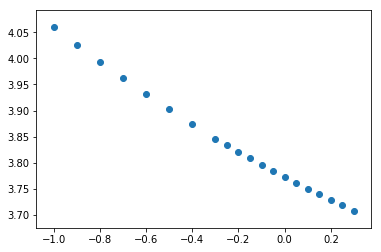

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#cubic lattice parameters as function of additional electrons/f.u.
doping_values = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
lattice_parameters = [4.059092994, 4.025409504, 3.993346465, 3.962317639, 3.932116563, 3.902865482, 3.874375354, 3.8459745, 3.8332674, 3.8206963, 3.8082354, 3.7959315, \
                      3.7837266, 3.7717999, 3.7609798,
                      3.7502701, 3.7396179, 3.7290455, 3.7185900, 3.7082016]

print(doping_values[11])
print(lattice_parameters[11])


plt.scatter(doping_values, lattice_parameters)

